In [ ]:
#Version 7: CNN 2D

In [ ]:
#Librerias
from time import time
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

eje=np.zeros((136,136))  #Imagen CT sintetica
npix=64 #Tamaño parche
corte=100 #Corte del estudio (271x271)

In [ ]:
#Funcion para ver los datos de los estudios
def datosImagen(data,letra,num):
  mindata,maxdata=np.min(data),np.max(data)
  print("data"+letra+num," ",'Minimo: ',mindata,', Maximo: ',maxdata,', Tamaño: ',data.shape,', Canales: ',data.ndim)

In [ ]:
#Funciones para Normalizar y Desnormalizar una imagen
import numpy as np

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def Un_NormalizeData(data,minData,maxData):
    return (data*(maxData-minData)+minData)

In [ ]:
#Funcion para bajar la resolucion de los estudios a la mitad: 271x271 -> 136z136
def LowResolutionData(data):
  arr=data[0:data.shape[0]:2,0:data.shape[1]:2]
  return arr

In [ ]:
#Funcion que sirve para construir la imagen sintetica CT parche por parche
def construirImage(imag,cord1,cord2):
  global eje
  imagen=imag
  pos=cord1
  pos2=cord2
  cnt=0
  for i in range(0,271):
    if(i>=pos2 and i<pos2+npix):
      #print(i,"=============",cnt)
      cnt2=0
      for j in range(0,271):
        if(j>=pos and j<pos+npix):
          #print(j,cnt2)
          eje[i][j]=imagen[cnt][cnt2]
          cnt2+=1
      cnt+=1


In [ ]:
#Funciones que sirven para eliminar los valores atipicos (mayores y menores) de la CT sintetica,
#reemplazando los valores atipicos por datos de entrenamiento
def eliminarMax(data,maximos):
  global maxTrain
  tam=maximos[0].shape[0]
  i=0
  while(i<tam):
    posx=maximos[0][i]
    posy=maximos[1][i]
    data[posx,posy]=maxTrain
    i+=1
  return data

def eliminarMin(data,minimos):
  global minTrain
  tam=minimos[0].shape[0]
  i=0
  while(i<tam):
    posx=minimos[0][i]
    posy=minimos[1][i]
    data[posx,posy]=minTrain
    i+=1
  return data

In [ ]:
#Modelo
from tensorflow import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Flatten, Activation, Dropout, BatchNormalization, concatenate, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D, Conv2DTranspose


# Definimos la entrada al modelo
Image_input = Input((npix, npix, 1))
Image_in = Image_input

#contracting path
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(Image_in)
conv1 = Dropout(0.1)(conv1)
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
maxp1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(maxp1)
conv2 = Dropout(0.1)(conv2)
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
maxp2 = MaxPooling2D((2, 2))(conv2)
 
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(maxp2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
maxp3 = MaxPooling2D((2, 2))(conv3)
 
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(maxp3)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
maxp4 = MaxPooling2D(pool_size=(2, 2))(conv4)
 
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(maxp4)
conv5 = Dropout(0.3)(conv5)
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

#expansive path
up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
up6 = concatenate([up6, conv4])
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
conv6 = Dropout(0.2)(conv6)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
 
up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
up7 = concatenate([up7, conv3])
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
conv7 = Dropout(0.2)(conv7)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
 
up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
up8 = concatenate([up8, conv2])
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
conv8 = Dropout(0.1)(conv8)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
 
up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
up9 = concatenate([up9, conv1], axis=3)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
conv9 = Dropout(0.1)(conv9)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
 
outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
 
model = Model(inputs=[Image_input], outputs=[outputs])
opt = keras.optimizers.Adam(learning_rate=0.0009)
model.compile(loss="MeanAbsoluteError", optimizer=opt)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   640         ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 64, 64, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 64)   36928       ['dropout[0][0]']                
                                                                                              

In [ ]:
#Leer estudios
#MRI
img_MRI1 = nib.load('001_MRI.nii.gz')
datax1 = img_MRI1.get_fdata()
img_MRI2 = nib.load('002_MRI.nii.gz')
datax2 = img_MRI2.get_fdata()
img_MRI3 = nib.load('003_MRI.nii.gz')
datax3 = img_MRI3.get_fdata()
img_MRI4 = nib.load('004_MRI.nii.gz')
datax4 = img_MRI4.get_fdata()
img_MRI5 = nib.load('005_MRI.nii.gz')
datax5 = img_MRI5.get_fdata()
img_MRI6 = nib.load('006_MRI.nii.gz')
datax6 = img_MRI6.get_fdata()
img_MRI7 = nib.load('007_MRI.nii.gz')
datax7 = img_MRI7.get_fdata()
img_MRI8 = nib.load('008_MRI.nii.gz')
datax8 = img_MRI8.get_fdata()
img_MRI9 = nib.load('009_MRI.nii.gz')
datax9 = img_MRI9.get_fdata()
img_MRI10 = nib.load('010_MRI.nii.gz')
datax10 = img_MRI10.get_fdata()

#CTs
img_CT1 = nib.load('001_CT.nii.gz')
datay1 = img_CT1.get_fdata() 
img_CT2 = nib.load('002_CT.nii.gz')
datay2 = img_CT2.get_fdata()
img_CT3 = nib.load('003_CT.nii.gz')
datay3 = img_CT3.get_fdata()
img_CT4 = nib.load('004_CT.nii.gz')
datay4 = img_CT4.get_fdata()
img_CT5 = nib.load('005_CT.nii.gz')
datay5 = img_CT5.get_fdata()
img_CT6 = nib.load('006_CT.nii.gz')
datay6 = img_CT6.get_fdata()
img_CT7 = nib.load('007_CT.nii.gz')
datay7 = img_CT7.get_fdata()
img_CT8 = nib.load('008_CT.nii.gz')
datay8 = img_CT8.get_fdata()
img_CT9 = nib.load('009_CT.nii.gz')
datay9 = img_CT9.get_fdata()
img_CT10 = nib.load('010_CT.nii.gz')
datay10 = img_CT10.get_fdata()

In [ ]:
#Visualziar Estudios
print("Estudios MRI")
datosImagen(datax1,"x","1")
datosImagen(datax2,"x","2")
datosImagen(datax3,"x","3")
datosImagen(datax4,"x","4")
datosImagen(datax5,"x","5")
datosImagen(datax6,"x","6")
datosImagen(datax7,"x","7")
datosImagen(datax8,"x","8")
datosImagen(datax9,"x","9")
datosImagen(datax10,"x","10")
print()
print("Estudios CTs")
datosImagen(datay1,"y","1")
datosImagen(datay2,"y","2")
datosImagen(datay3,"y","3")
datosImagen(datay4,"y","4")
datosImagen(datay5,"y","5")
datosImagen(datay6,"y","6")
datosImagen(datay7,"y","7")
datosImagen(datay8,"y","8")
datosImagen(datay9,"y","9")
datosImagen(datay10,"y","10")
print()

Estudios MRI
datax1   Minimo:  0.0 , Maximo:  255.0 , Tamaño:  (271, 271, 221) , Canales:  3
datax2   Minimo:  0.0 , Maximo:  255.0 , Tamaño:  (271, 271, 221) , Canales:  3
datax3   Minimo:  0.0 , Maximo:  255.0 , Tamaño:  (271, 271, 221) , Canales:  3
datax4   Minimo:  0.0 , Maximo:  255.0 , Tamaño:  (271, 271, 221) , Canales:  3
datax5   Minimo:  0.0 , Maximo:  255.0 , Tamaño:  (271, 271, 221) , Canales:  3
datax6   Minimo:  0.0 , Maximo:  255.0 , Tamaño:  (271, 271, 221) , Canales:  3
datax7   Minimo:  0.0 , Maximo:  255.0 , Tamaño:  (271, 271, 221) , Canales:  3
datax8   Minimo:  0.0 , Maximo:  255.0 , Tamaño:  (271, 271, 221) , Canales:  3
datax9   Minimo:  0.0 , Maximo:  255.0 , Tamaño:  (271, 271, 221) , Canales:  3
datax10   Minimo:  0.0 , Maximo:  255.0 , Tamaño:  (271, 271, 221) , Canales:  3

Estudios CTs
datay1   Minimo:  -1025.0 , Maximo:  3110.0 , Tamaño:  (271, 271, 221) , Canales:  3
datay2   Minimo:  -1918.0 , Maximo:  3994.0 , Tamaño:  (271, 271, 221) , Canales:  3
da

In [ ]:
#Low Resolution Estudios
#MRI
datax1LR=LowResolutionData(datax1)
datax2LR=LowResolutionData(datax2)
datax3LR=LowResolutionData(datax3)
datax4LR=LowResolutionData(datax4)
datax5LR=LowResolutionData(datax5)
datax6LR=LowResolutionData(datax6)
datax7LR=LowResolutionData(datax7)
datax8LR=LowResolutionData(datax8)
datax9LR=LowResolutionData(datax9)
datax10LR=LowResolutionData(datax10)

#CTs
datay1LR=LowResolutionData(datay1)
datay2LR=LowResolutionData(datay2)
datay3LR=LowResolutionData(datay3)
datay4LR=LowResolutionData(datay4)
datay5LR=LowResolutionData(datay5)
datay6LR=LowResolutionData(datay6)
datay7LR=LowResolutionData(datay7)
datay8LR=LowResolutionData(datay8)
datay9LR=LowResolutionData(datay9)
datay10LR=LowResolutionData(datay10)

In [ ]:
#Visualziar Estudios
print("Estudios MRI LR")
datosImagen(datax1LR,"x","1")
datosImagen(datax2LR,"x","2")
datosImagen(datax3LR,"x","3")
datosImagen(datax4LR,"x","4")
datosImagen(datax5LR,"x","5")
datosImagen(datax6LR,"x","6")
datosImagen(datax7LR,"x","7")
datosImagen(datax8LR,"x","8")
datosImagen(datax9LR,"x","9")
datosImagen(datax10LR,"x","10")
print()
print("Estudios CTs LR")
datosImagen(datay1LR,"y","1")
datosImagen(datay2LR,"y","2")
datosImagen(datay3LR,"y","3")
datosImagen(datay4LR,"y","4")
datosImagen(datay5LR,"y","5")
datosImagen(datay6LR,"y","6")
datosImagen(datay7LR,"y","7")
datosImagen(datay8LR,"y","8")
datosImagen(datay9LR,"y","9")
datosImagen(datay10LR,"y","10")
print()

Estudios MRI LR
datax1   Minimo:  3.0 , Maximo:  251.0 , Tamaño:  (136, 136, 221) , Canales:  3
datax2   Minimo:  0.0 , Maximo:  244.0 , Tamaño:  (136, 136, 221) , Canales:  3
datax3   Minimo:  1.0 , Maximo:  255.0 , Tamaño:  (136, 136, 221) , Canales:  3
datax4   Minimo:  0.0 , Maximo:  250.0 , Tamaño:  (136, 136, 221) , Canales:  3
datax5   Minimo:  1.0 , Maximo:  251.0 , Tamaño:  (136, 136, 221) , Canales:  3
datax6   Minimo:  2.0 , Maximo:  245.0 , Tamaño:  (136, 136, 221) , Canales:  3
datax7   Minimo:  0.0 , Maximo:  252.0 , Tamaño:  (136, 136, 221) , Canales:  3
datax8   Minimo:  1.0 , Maximo:  255.0 , Tamaño:  (136, 136, 221) , Canales:  3
datax9   Minimo:  2.0 , Maximo:  245.0 , Tamaño:  (136, 136, 221) , Canales:  3
datax10   Minimo:  3.0 , Maximo:  242.0 , Tamaño:  (136, 136, 221) , Canales:  3

Estudios CTs LR
datay1   Minimo:  -1024.0 , Maximo:  3096.0 , Tamaño:  (136, 136, 221) , Canales:  3
datay2   Minimo:  -1790.0 , Maximo:  3710.0 , Tamaño:  (136, 136, 221) , Canales:

In [ ]:
#Normalizar Estudios
#MRI
datax1N=NormalizeData(datax1LR)
datax2N=NormalizeData(datax2LR)
datax3N=NormalizeData(datax3LR)
datax4N=NormalizeData(datax4LR)
datax5N=NormalizeData(datax5LR)
datax6N=NormalizeData(datax6LR)
datax7N=NormalizeData(datax7LR)
datax8N=NormalizeData(datax8LR)
datax9N=NormalizeData(datax9LR)
datax10N=NormalizeData(datax10LR)

#CTs
datay1N=NormalizeData(datay1LR)
datay2N=NormalizeData(datay2LR)
datay3N=NormalizeData(datay3LR)
datay4N=NormalizeData(datay4LR)
datay5N=NormalizeData(datay5LR)
datay6N=NormalizeData(datay6LR)
datay7N=NormalizeData(datay7LR)
datay8N=NormalizeData(datay8LR)
datay9N=NormalizeData(datay9LR)
datay10N=NormalizeData(datay10LR)

In [ ]:
#Visualziar Estudios Normalizados
print("Estudios Normalizados MRI")
datosImagen(datax1N,"x","1")
datosImagen(datax2N,"x","2")
datosImagen(datax3N,"x","3")
datosImagen(datax4N,"x","4")
datosImagen(datax5N,"x","5")
datosImagen(datax6N,"x","6")
datosImagen(datax7N,"x","7")
datosImagen(datax8N,"x","8")
datosImagen(datax9N,"x","9")
datosImagen(datax10N,"x","10")
print()
print("Estudios Normalizados CTs")
datosImagen(datay1N,"y","1")
datosImagen(datay2N,"y","2")
datosImagen(datay3N,"y","3")
datosImagen(datay4N,"y","4")
datosImagen(datay5N,"y","5")
datosImagen(datay6N,"y","6")
datosImagen(datay7N,"y","7")
datosImagen(datay8N,"y","8")
datosImagen(datay9N,"y","9")
datosImagen(datay10N,"y","10")
print()

Estudios Normalizados MRI
datax1   Minimo:  0.0 , Maximo:  1.0 , Tamaño:  (136, 136, 221) , Canales:  3
datax2   Minimo:  0.0 , Maximo:  1.0 , Tamaño:  (136, 136, 221) , Canales:  3
datax3   Minimo:  0.0 , Maximo:  1.0 , Tamaño:  (136, 136, 221) , Canales:  3
datax4   Minimo:  0.0 , Maximo:  1.0 , Tamaño:  (136, 136, 221) , Canales:  3
datax5   Minimo:  0.0 , Maximo:  1.0 , Tamaño:  (136, 136, 221) , Canales:  3
datax6   Minimo:  0.0 , Maximo:  1.0 , Tamaño:  (136, 136, 221) , Canales:  3
datax7   Minimo:  0.0 , Maximo:  1.0 , Tamaño:  (136, 136, 221) , Canales:  3
datax8   Minimo:  0.0 , Maximo:  1.0 , Tamaño:  (136, 136, 221) , Canales:  3
datax9   Minimo:  0.0 , Maximo:  1.0 , Tamaño:  (136, 136, 221) , Canales:  3
datax10   Minimo:  0.0 , Maximo:  1.0 , Tamaño:  (136, 136, 221) , Canales:  3

Estudios Normalizados CTs
datay1   Minimo:  0.0 , Maximo:  1.0 , Tamaño:  (136, 136, 221) , Canales:  3
datay2   Minimo:  0.0 , Maximo:  1.0 , Tamaño:  (136, 136, 221) , Canales:  3
datay3   M

In [ ]:
#Visualziar Datos en el Corte Asignado
print("Corte",corte,"MRI")
datosImagen(datax1[:,:,corte],"x","1")
datosImagen(datax2[:,:,corte],"x","2")
datosImagen(datax3[:,:,corte],"x","3")
datosImagen(datax4[:,:,corte],"x","4")
datosImagen(datax5[:,:,corte],"x","5")
datosImagen(datax6[:,:,corte],"x","6")
datosImagen(datax7[:,:,corte],"x","7")
datosImagen(datax8[:,:,corte],"x","8")
datosImagen(datax9[:,:,corte],"x","9")
datosImagen(datax10[:,:,corte],"x","10")
print()
print("Corte",corte,"CTs")
datosImagen(datay1[:,:,corte],"y","1")
datosImagen(datay2[:,:,corte],"y","2")
datosImagen(datay3[:,:,corte],"y","3")
datosImagen(datay4[:,:,corte],"y","4")
datosImagen(datay5[:,:,corte],"y","5")
datosImagen(datay6[:,:,corte],"y","6")
datosImagen(datay7[:,:,corte],"y","7")
datosImagen(datay8[:,:,corte],"y","8")
datosImagen(datay9[:,:,corte],"y","9")
datosImagen(datay10[:,:,corte],"y","10")
print()

Corte 100 MRI
datax1   Minimo:  10.0 , Maximo:  212.0 , Tamaño:  (271, 271) , Canales:  2
datax2   Minimo:  7.0 , Maximo:  184.0 , Tamaño:  (271, 271) , Canales:  2
datax3   Minimo:  7.0 , Maximo:  205.0 , Tamaño:  (271, 271) , Canales:  2
datax4   Minimo:  9.0 , Maximo:  204.0 , Tamaño:  (271, 271) , Canales:  2
datax5   Minimo:  6.0 , Maximo:  213.0 , Tamaño:  (271, 271) , Canales:  2
datax6   Minimo:  9.0 , Maximo:  204.0 , Tamaño:  (271, 271) , Canales:  2
datax7   Minimo:  7.0 , Maximo:  191.0 , Tamaño:  (271, 271) , Canales:  2
datax8   Minimo:  9.0 , Maximo:  192.0 , Tamaño:  (271, 271) , Canales:  2
datax9   Minimo:  9.0 , Maximo:  173.0 , Tamaño:  (271, 271) , Canales:  2
datax10   Minimo:  10.0 , Maximo:  195.0 , Tamaño:  (271, 271) , Canales:  2

Corte 100 CTs
datay1   Minimo:  -1024.0 , Maximo:  3070.0 , Tamaño:  (271, 271) , Canales:  2
datay2   Minimo:  -1075.0 , Maximo:  3053.0 , Tamaño:  (271, 271) , Canales:  2
datay3   Minimo:  -1067.0 , Maximo:  3084.0 , Tamaño:  (27

In [ ]:
#Visualziar Datos Normalizados en el Corte Asignado
print("Corte",corte,"MRI")
datosImagen(datax1N[:,:,corte],"x","1")
datosImagen(datax2N[:,:,corte],"x","2")
datosImagen(datax3N[:,:,corte],"x","3")
datosImagen(datax4N[:,:,corte],"x","4")
datosImagen(datax5N[:,:,corte],"x","5")
datosImagen(datax6N[:,:,corte],"x","6")
datosImagen(datax7N[:,:,corte],"x","7")
datosImagen(datax8N[:,:,corte],"x","8")
datosImagen(datax9N[:,:,corte],"x","9")
datosImagen(datax10N[:,:,corte],"x","10")
print()
print("Corte",corte,"CTs")
datosImagen(datay1N[:,:,corte],"y","1")
datosImagen(datay2N[:,:,corte],"y","2")
datosImagen(datay3N[:,:,corte],"y","3")
datosImagen(datay4N[:,:,corte],"y","4")
datosImagen(datay5N[:,:,corte],"y","5")
datosImagen(datay6N[:,:,corte],"y","6")
datosImagen(datay7N[:,:,corte],"y","7")
datosImagen(datay8N[:,:,corte],"y","8")
datosImagen(datay9N[:,:,corte],"y","9")
datosImagen(datay10N[:,:,corte],"y","10")
print()

Corte 100 MRI
datax1   Minimo:  0.028225806451612902 , Maximo:  0.842741935483871 , Tamaño:  (136, 136) , Canales:  2
datax2   Minimo:  0.028688524590163935 , Maximo:  0.7295081967213115 , Tamaño:  (136, 136) , Canales:  2
datax3   Minimo:  0.031496062992125984 , Maximo:  0.7716535433070866 , Tamaño:  (136, 136) , Canales:  2
datax4   Minimo:  0.036 , Maximo:  0.816 , Tamaño:  (136, 136) , Canales:  2
datax5   Minimo:  0.032 , Maximo:  0.848 , Tamaño:  (136, 136) , Canales:  2
datax6   Minimo:  0.03292181069958848 , Maximo:  0.7654320987654321 , Tamaño:  (136, 136) , Canales:  2
datax7   Minimo:  0.027777777777777776 , Maximo:  0.7380952380952381 , Tamaño:  (136, 136) , Canales:  2
datax8   Minimo:  0.03543307086614173 , Maximo:  0.7362204724409449 , Tamaño:  (136, 136) , Canales:  2
datax9   Minimo:  0.03292181069958848 , Maximo:  0.7037037037037037 , Tamaño:  (136, 136) , Canales:  2
datax10   Minimo:  0.03347280334728033 , Maximo:  0.803347280334728 , Tamaño:  (136, 136) , Canales: 

In [ ]:
Zo=99
Z=104
def TrainTest(data):
  tam=Z-Zo
  arr=[]
  for i in range(tam):
    arr.append(data[:,:,i])
  return arr

In [ ]:
#Funcion para encontrar el maximo y minimo de entrenamiento en el corte CT asignado
def MaxMinTraining(corte1,corte2,corte3,corte4,corte5,corte6):
  arrMax=np.array([corte1.max(),corte2.max(),corte3.max(),corte4.max(),corte5.max(),corte6.max()])
  arrMin=np.array([corte1.min(),corte2.min(),corte3.min(),corte4.min(),corte5.min(),corte6.min()])
  return arrMax.max(),arrMin.min()

maxTrain,minTrain=MaxMinTraining(datay1[:,:,corte],datay3[:,:,corte],datay5[:,:,corte],datay7[:,:,corte],datay9[:,:,corte],datay10[:,:,corte])
print(maxTrain,minTrain)

3136.0 -1158.0


In [ ]:
#Separacion por parches
tamImage=271
tamImage2=271
inicio2=15
while(inicio2<tamImage2):
  inicio=15
  while(inicio<tamImage):
    #Parche MRI
    Itempx1=datax1N[inicio:inicio+npix,inicio2:inicio2+npix,Zo:Z]
    Itempx2=datax2N[inicio:inicio+npix,inicio2:inicio2+npix,Zo:Z]
    Itempx3=datax3N[inicio:inicio+npix,inicio2:inicio2+npix,Zo:Z]
    Itempx4=datax4N[inicio:inicio+npix,inicio2:inicio2+npix,Zo:Z]
    Itempx5=datax5N[inicio:inicio+npix,inicio2:inicio2+npix,Zo:Z]
    Itempx6=datax6N[inicio:inicio+npix,inicio2:inicio2+npix,Zo:Z]
    Itempx7=datax7N[inicio:inicio+npix,inicio2:inicio2+npix,Zo:Z]
    Itempx8=datax8N[inicio:inicio+npix,inicio2:inicio2+npix,Zo:Z]
    Itempx9=datax9N[inicio:inicio+npix,inicio2:inicio2+npix,Zo:Z]
    Itempx10=datax10N[inicio:inicio+npix,inicio2:inicio2+npix,Zo:Z]

    #Parche CTs
    Itempy1=datay1N[inicio:inicio+npix,inicio2:inicio2+npix,Zo:Z]
    Itempy2=datay2N[inicio:inicio+npix,inicio2:inicio2+npix,Zo:Z]
    Itempy3=datay3N[inicio:inicio+npix,inicio2:inicio2+npix,Zo:Z]
    Itempy4=datay4N[inicio:inicio+npix,inicio2:inicio2+npix,Zo:Z]
    Itempy5=datay5N[inicio:inicio+npix,inicio2:inicio2+npix,Zo:Z]
    Itempy6=datay6N[inicio:inicio+npix,inicio2:inicio2+npix,Zo:Z]
    Itempy7=datay7N[inicio:inicio+npix,inicio2:inicio2+npix,Zo:Z]
    Itempy8=datay8N[inicio:inicio+npix,inicio2:inicio2+npix,Zo:Z]
    Itempy9=datay9N[inicio:inicio+npix,inicio2:inicio2+npix,Zo:Z]
    Itempy10=datay10N[inicio:inicio+npix,inicio2:inicio2+npix,Zo:Z]
    
    #===========================================================================================
    #Datos de entrenamiento y test
    #MRI
    XTrain1=TrainTest(Itempx1)
    XTrain2=TrainTest(Itempx3)
    XTrain3=TrainTest(Itempx5)
    XTrain4=TrainTest(Itempx7) 
    XTrain5=TrainTest(Itempx9) 
    XTrain6=TrainTest(Itempx10)  
    XTest1=TrainTest(Itempx2)  
    XTest2=TrainTest(Itempx4) 
    XTest3=TrainTest(Itempx6) 
    XTest4=TrainTest(Itempx8)   
    #======================================================================================================
    #Datos de entrenamiento y test
    #CTs
    YTrain1=TrainTest(Itempy1)  
    YTrain2=TrainTest(Itempy3) 
    YTrain3=TrainTest(Itempy5) 
    YTrain4=TrainTest(Itempy7) 
    YTrain5=TrainTest(Itempy9) 
    YTrain6=TrainTest(Itempy10) 
    YTest1=TrainTest(Itempy2) 
    YTest2=TrainTest(Itempy4) 
    YTest3=TrainTest(Itempy6) 
    YTest4=TrainTest(Itempy8) 
    #=======================================================================================================
    #Juntar estudios
    XTrain=np.array(XTrain1+XTrain2+XTrain3+XTrain4+XTrain5+XTrain6)
    XTrain=XTrain.reshape(XTrain.shape[0],XTrain.shape[1],XTrain.shape[2],1)
    print(XTrain.shape)
    
    XTest=np.array(XTest2[1])
    XTest=XTest.reshape(1,XTest.shape[0],XTest.shape[1], 1)
    print(XTest.shape)

    YTrain=np.array(YTrain1+YTrain2+YTrain3+YTrain4+YTrain5+YTrain6)
    YTrain=YTrain.reshape(YTrain.shape[0],YTrain.shape[1],YTrain.shape[2],1)
    print(YTrain.shape)

    YTest=np.array(YTest2[1])
    YTest=YTest.reshape(1,YTest.shape[0],YTest.shape[1], 1)
    print(YTest.shape)
    #================================================================================================================
    #Entrenar modelo
    model.fit(XTrain, YTrain, batch_size=75,epochs=600, verbose=0)
    ypred = model.predict(XTest)
    #Construir CT Sintetica
    Ipred=ypred.reshape(npix,-1)
    construirImage(Ipred,inicio2,inicio)
    print("Finish:============================================")
    inicio+=npix
    #finishSegundoWhile
  inicio2+=npix
  #finishSegundoWhile

#Desnormalizar la prediccion
eje=Un_NormalizeData(eje,datay4.min(),datay4.max())

#Buscamos los minimos y maximos en la imagen completa
minimos=np.where(eje<minTrain)
maximos=np.where(eje>maxTrain)
eje=eliminarMax(eje,maximos)
eje=eliminarMin(eje,minimos)

(30, 64, 64, 1)
(1, 64, 64, 1)
(30, 64, 64, 1)
(1, 64, 64, 1)
Finish:============================================


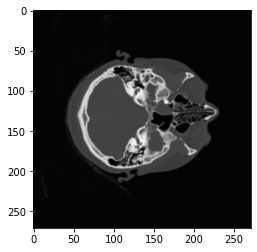

In [ ]:
plt.imshow(datay4[:,:,100], cmap="gray")

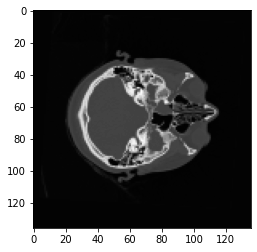

In [ ]:
plt.imshow(datay4LR[:,:,100], cmap="gray")

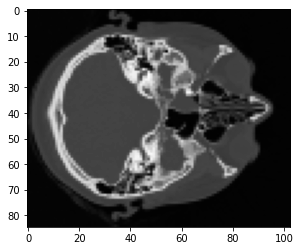

In [ ]:
plt.imshow(datay4LR[25:110,20:123,100], cmap="gray")

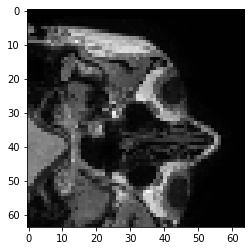

In [ ]:
plt.imshow(datax4LR[25:89,59:123,100], cmap="gray")

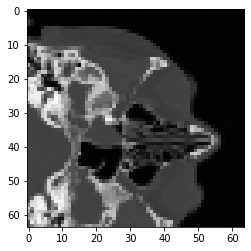

In [ ]:
plt.imshow(datay4LR[25:89,59:123,100], cmap="gray")

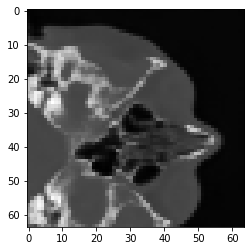

In [ ]:
plt.imshow(eje[25:89,59:123], cmap="gray")

In [ ]:
from skimage.transform import resize
eje2=resize(eje,(271,271), anti_aliasing=True)
print(eje2.shape)

(271, 271)


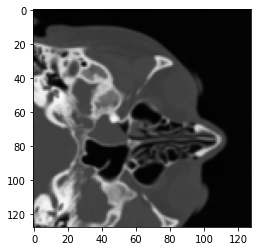

In [ ]:
plt.imshow(datay4[50:178,118:246,100], cmap="gray")

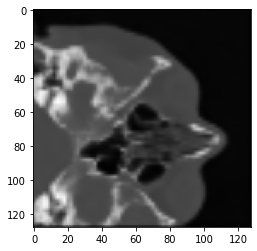

In [ ]:
plt.imshow(eje2[50:178,118:246], cmap="gray")

In [ ]:
np.savetxt("CNN2DNoGPUP2.csv", eje2[50:178,118:246], delimiter=",")